##### Student Name: Nayem Alam
##### Student ID  : 260743549
##### Assignment 3

## Part 2.1 - Depth Estimation
    Q. 1,2,3

In [1]:
# READ PFM directly (code given by TA in this folder)
import sys
import re
from struct import *
import numpy as np
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img

### a)
### importing and reading images from site

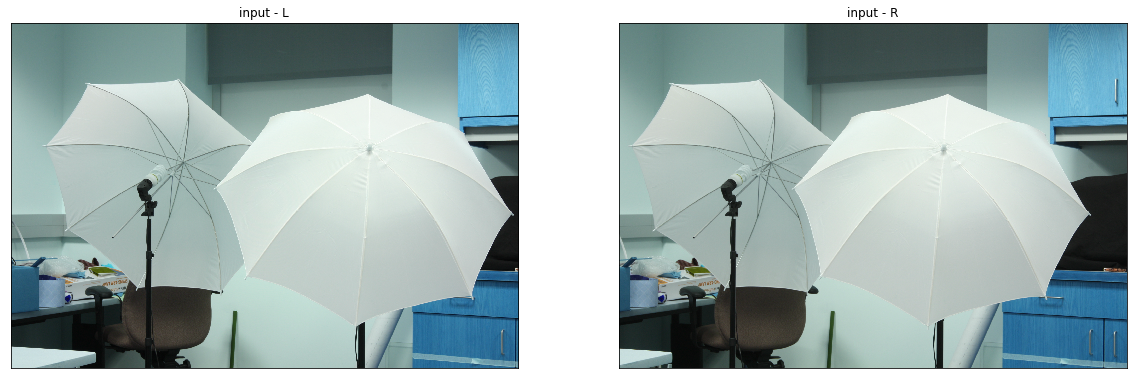

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from skimage import io

####  Didn't load using url because server kept timing o

# imgL = io.imread('http://vision.middlebury.edu/stereo/data/scenes2014/datasets/Umbrella-perfect/im0.png')
# imgR = io.imread('http://vision.middlebury.edu/stereo/data/scenes2014/datasets/Umbrella-perfect/im1.png')
# imgL_pfm = io.imread('http://vision.middlebury.edu/stereo/data/scenes2014/datasets/Umbrella-perfect/disp0.pfm')
# imgR_pfm = io.imread('http://vision.middlebury.edu/stereo/data/scenes2014/datasets/Umbrella-perfect/disp1.pfm')

# Read and display images form http://vision.middlebury.edu/stereo/data/ --- Using 2014 image (Umbrella-perfect)
imgL = cv2.imread("./im0.png")
imgR = cv2.imread("./im1.png")

imgL_pfm = read_pfm("./disp0.pfm")
imgR_pfm = read_pfm("./disp1.pfm")

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(imgL, cmap="gray")
plt.title("input - L"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR, cmap="gray")
plt.title("input - R"), plt.xticks([]), plt.yticks([])
plt.show()

### Estimate depth using the stereo image pair... 

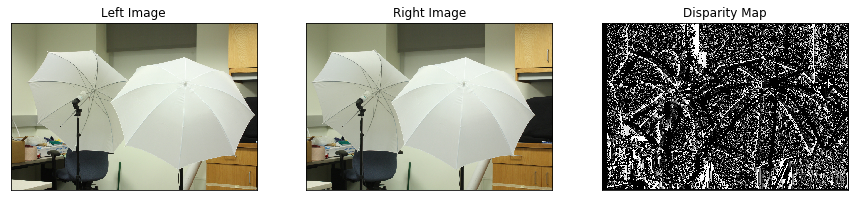

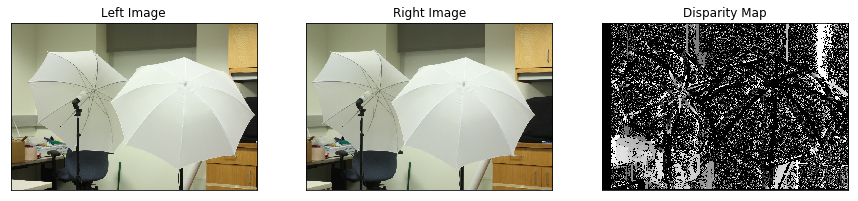

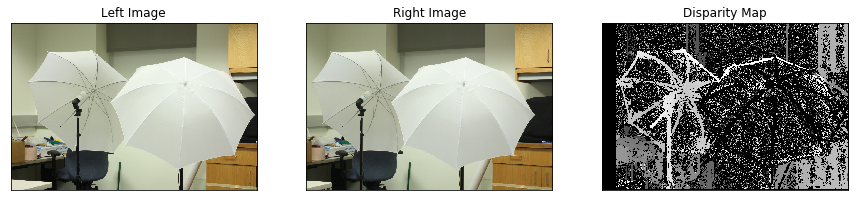

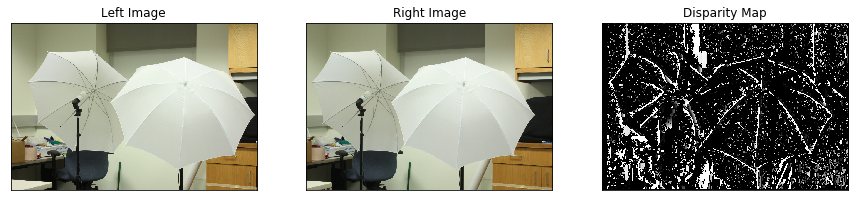

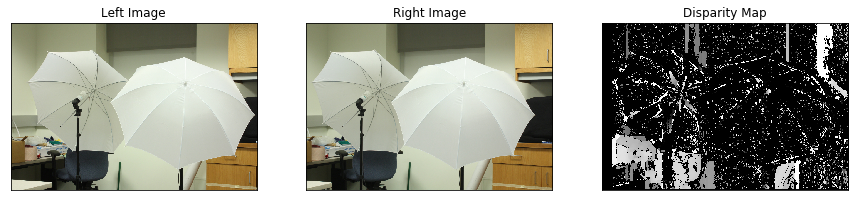

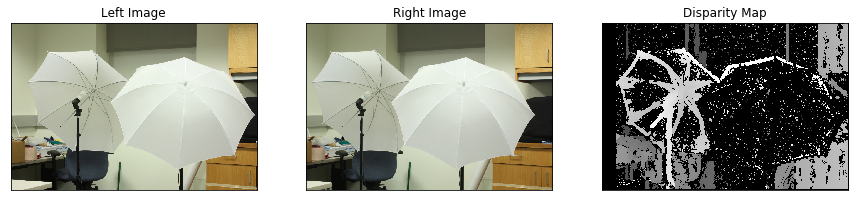

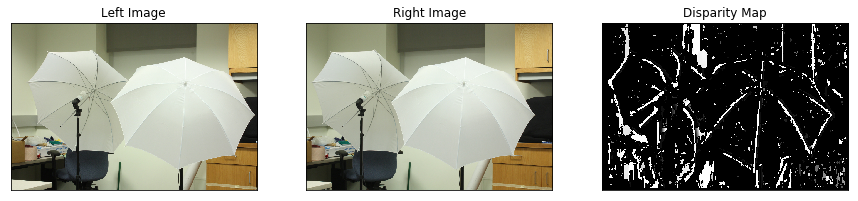

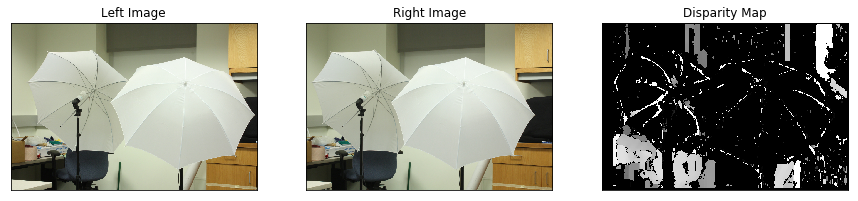

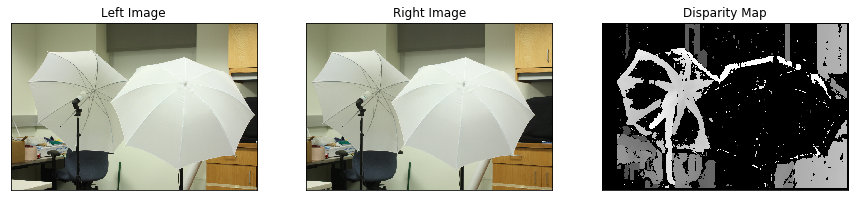

9


In [3]:
# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# compute disparity map
blockSize = [5,10-1,15] # 10 gives weird disparities, so I used 9
numDisparities = [16,32,48]
dispar = []

# 9 depth-maps
for i in range(len(blockSize)):
    for j in range(len(numDisparities)):
    
    # disparity map
        stereo = cv2.StereoBM_create(numDisparities=numDisparities[j], blockSize= blockSize[i])
        disparity = stereo.compute(imgL_gray, imgR_gray)
        dispar.append(disparity)

        # display 9 images
        plt.figure(figsize=(15,15))
        plt.subplot(131), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
        plt.title("Left Image"), plt.xticks([]), plt.yticks([])
        plt.subplot(132), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
        plt.title("Right Image"), plt.xticks([]), plt.yticks([])
        plt.subplot(133), plt.imshow(disparity, cmap="gray")
        plt.title("Disparity Map"), plt.xticks([]), plt.yticks([])
        plt.show()
print(len(dispar))

### b) 
### For each depth-map, compute the pixel-wise squared difference error with respect to the ground-truth.

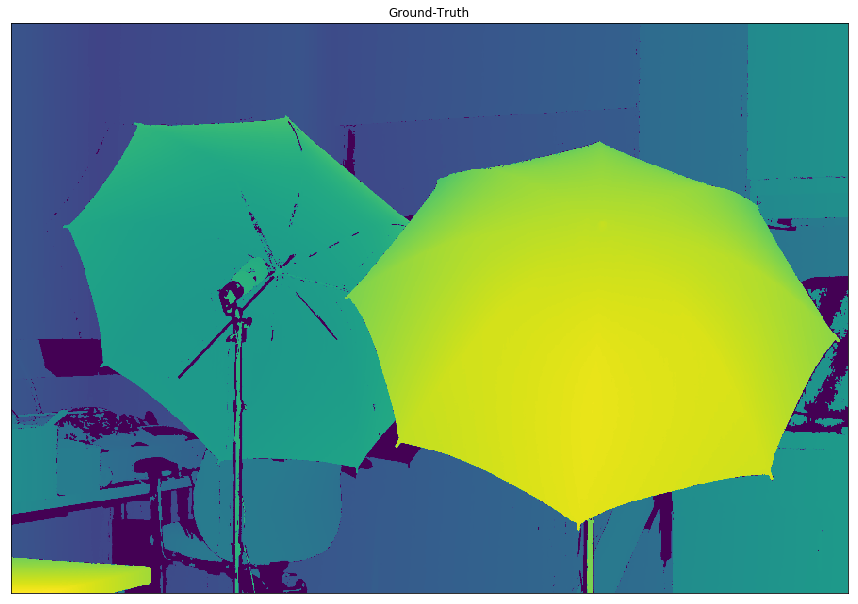

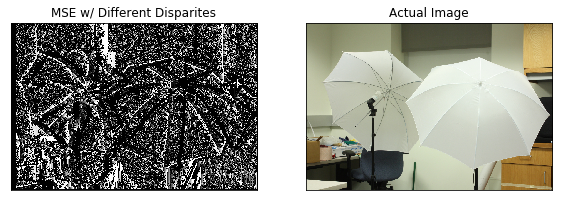

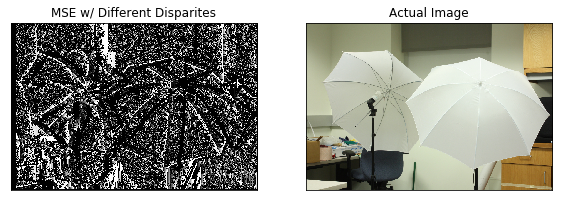

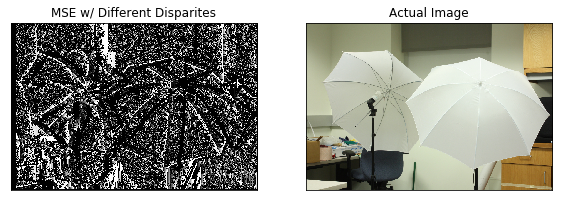

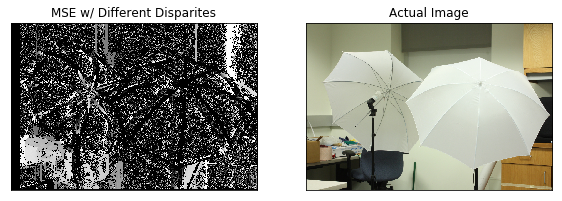

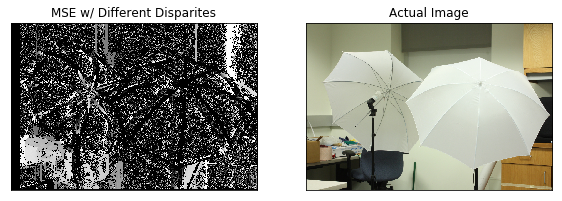

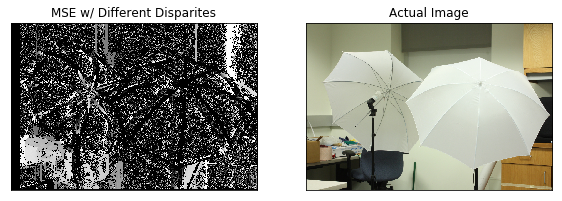

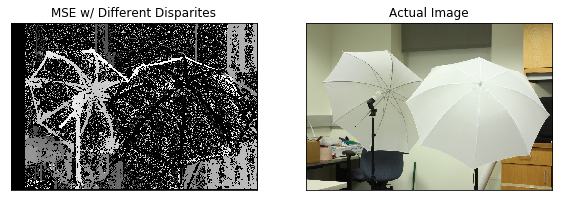

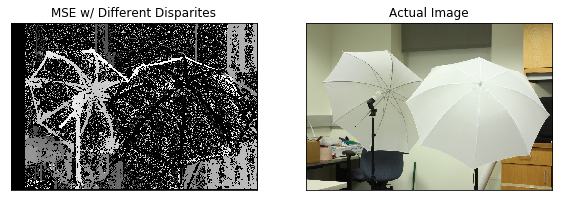

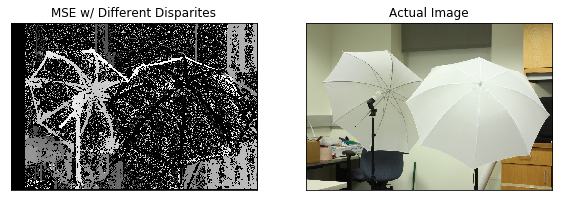

In [4]:
# compute sqrddiff (using function: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/)

# def squared_diff(imgA,imgB):
#     err = np.sum((imgA.astype("float") - imgB.astype("float")) ** 2)
#     err /= float(imgA.shape[0] * imgA.shape[1])
#     return err
# print(squared_diff(imgL_pfm, imgR_pfm))
imgL_pfm = read_pfm("./disp0.pfm")
squared_diff = []

# ground truth
imgL_pfm[imgL_pfm==np.inf] = 0
imgL_pfm = cv2.resize(imgL_pfm, None, fx=0.3, fy=0.3) # to broadcast with shape size (605,888)


for i in range(len(dispar)): 
#     mse = (((dispar[i] - imgL_pfm) ** 2).mean(axis=None))
    squared_diff.append(((dispar[i]-imgL_pfm)**2).mean(axis=None))

# plot the ground truth
plt.figure(figsize=(15,15))
plt.imshow(imgL_pfm)
plt.title('Ground-Truth'), plt.xticks([]), plt.yticks([])
plt.show()

# plot mse
for i in range(len(blockSize)):
    for j in range(len(numDisparities)):    
        
        plt.figure(figsize=(15,15))
        plt.subplot(131), plt.imshow(dispar[i], cmap="gray")
        plt.title("MSE w/ Different Disparites"), plt.xticks([]), plt.yticks([])
        plt.subplot(132), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
        plt.title("Actual Image"), plt.xticks([]), plt.yticks([])
        plt.show()

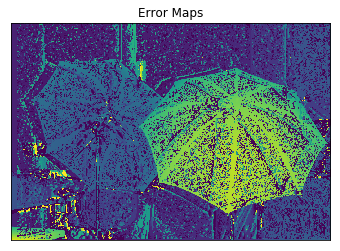

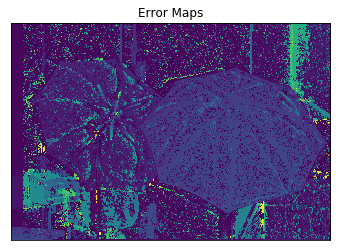

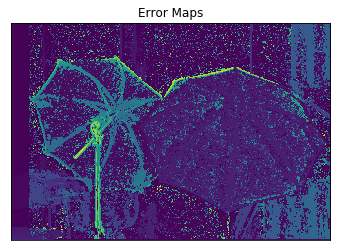

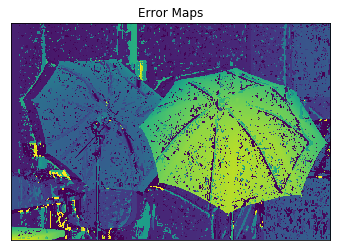

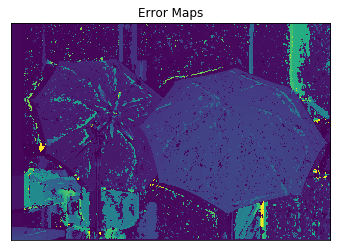

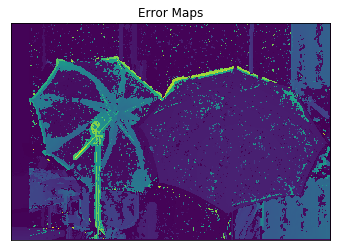

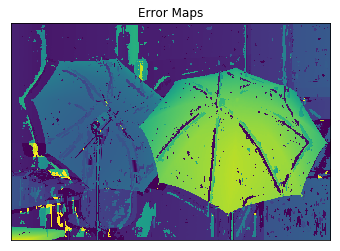

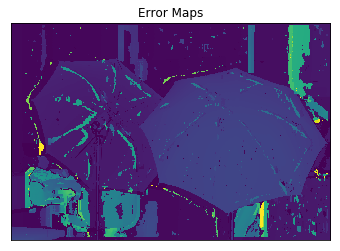

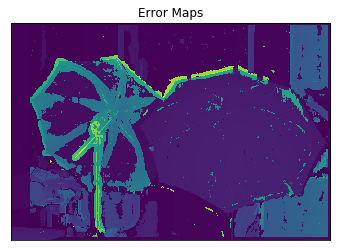

In [5]:
"""
PLOT ERROR MAPS
"""
        
mse = []
        
for i in range(len(dispar)):
    pixels = dispar[i] - imgL_pfm
    mse.append((pixels)*(pixels))
    
for k in range(len(mse)):
    plt.imshow(mse[k]),
    plt.title("Error Maps"), plt.xticks([]), plt.yticks([]) 
    plt.show()
# np.count_nonzero(squared_diff[axis])

### c)
### Comment on the error-maps for each combination of parameters. Specifically, mention the effects of varying the parameters on the error in the region of high/low texture, edge, large/small depths.
The two parameters in question here are the <u>blockSize</u> and the number of <u>disparities</u>. 

<ul>
    <li>blockSize: <br>
        As we increase this blockSize, it helps in lowering the noise around the edges. In general, blockSize is more of a user choice. The smaller the blockSize, the greater the depth (more stable). However, even though it helps in reducing noise around the edges, it doesn't help in differentiating the giving us details on the image such as, points of texture.
    </li>
    <li>Disparities: <br>
         Disparities depends on the image that we're using; as we can see on the umbrella (the image I'm using) there's not much differences between the right and left images, this is because there is small movement. In this case, our range of disparity between the umbrella images are not so big. However, on the contrary of blockSize, it helps in defining the depths and can truly focus on detail (finding points of texture at every edge).
    </li>
</ul>

In terms of <u>error maps</u>, we're told to use a blockSize of 9 and 48 disparities: this shows a nice error map, however we can conclude from this comment that the smaller the blockSize, the greater the depth (more stable) and increasing disparity is more effective than increasing blockSize when it comes to portraying a better defined error map.

###### References for images used:
[[5](http://www.cs.middlebury.edu/~schar/papers/datasets-gcpr2014.pdf)] D. Scharstein, H. Hirschmüller, Y. Kitajima, G. Krathwohl, N. Nesic, X. Wang, and P. Westling. High-resolution stereo datasets with subpixel-accurate ground truth.
In German Conference on Pattern Recognition (GCPR 2014), Münster, Germany, September 2014.